TESTING

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Statistical VaR and ES for INTC
Statistical VaR and ES for INTC at 95% confidence level: VaR=-0.0374, ES=-0.0470, Extreme Loss=5.00%
Statistical VaR and ES for INTC at 99% confidence level: VaR=-0.0530, ES=-0.0608, Extreme Loss=1.00%


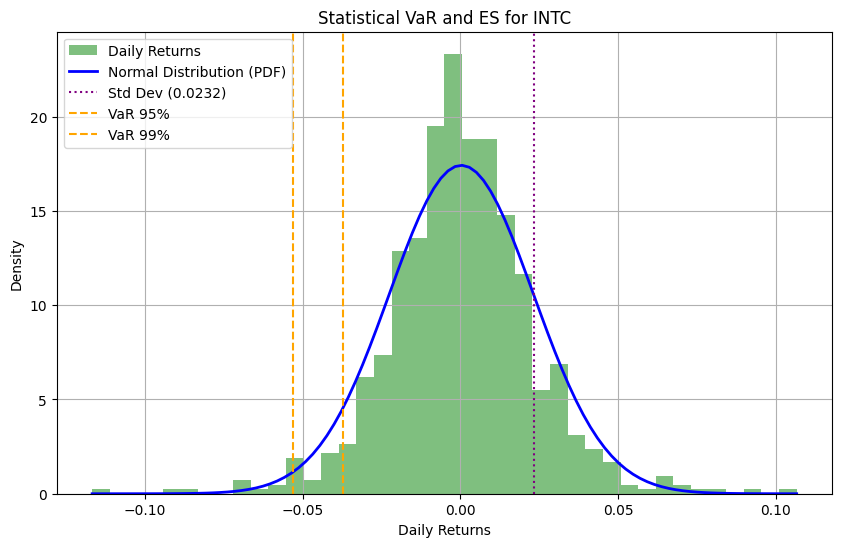


Statistical VaR and ES for AMD
Statistical VaR and ES for AMD at 95% confidence level: VaR=-0.0516, ES=-0.0650, Extreme Loss=5.00%
Statistical VaR and ES for AMD at 99% confidence level: VaR=-0.0735, ES=-0.0844, Extreme Loss=1.00%


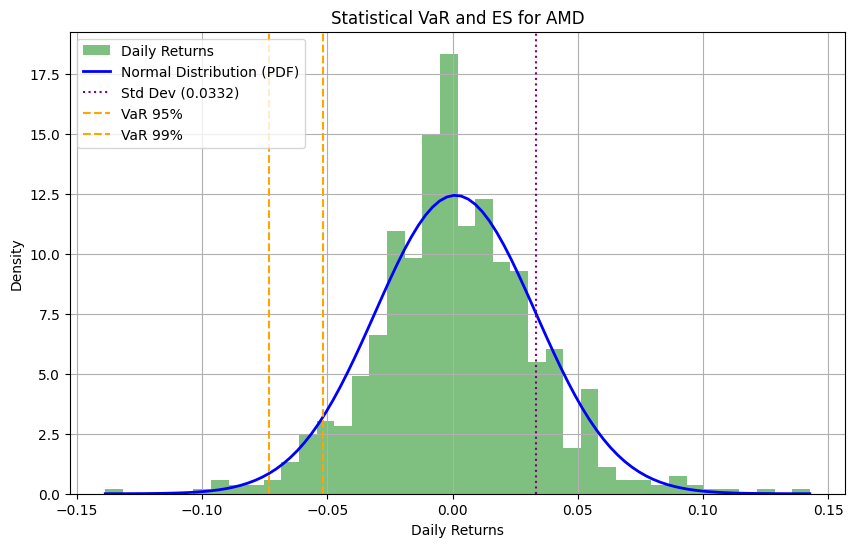


Statistical Portfolio VaR and ES
Statistical Portfolio VaR and ES at 95% confidence level: VaR=-0.0391, ES=-0.0492, Extreme Loss=5.00%
Statistical Portfolio VaR and ES at 99% confidence level: VaR=-0.0556, ES=-0.0638, Extreme Loss=1.00%


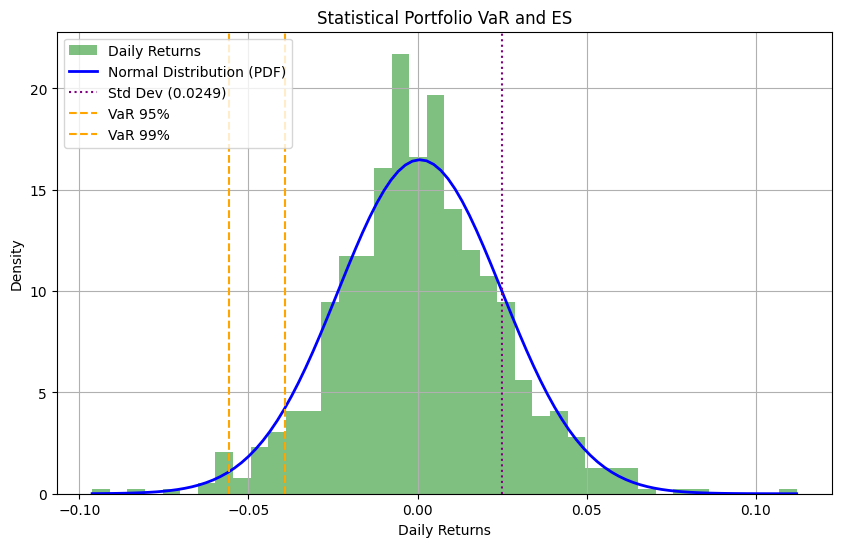


Historical VaR and ES for INTC
Historical VaR and ES for INTC at 95% confidence level: VaR=-0.0342, ES=-0.0515, Extreme Loss=5.00%
Historical VaR and ES for INTC at 99% confidence level: VaR=-0.0580, ES=-0.0789, Extreme Loss=1.00%


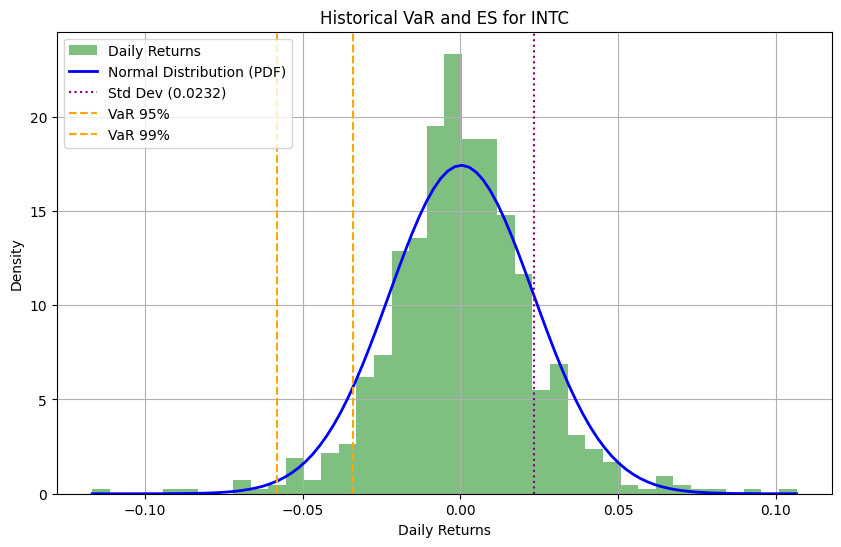


Historical VaR and ES for AMD
Historical VaR and ES for AMD at 95% confidence level: VaR=-0.0517, ES=-0.0674, Extreme Loss=5.00%
Historical VaR and ES for AMD at 99% confidence level: VaR=-0.0791, ES=-0.0952, Extreme Loss=1.00%


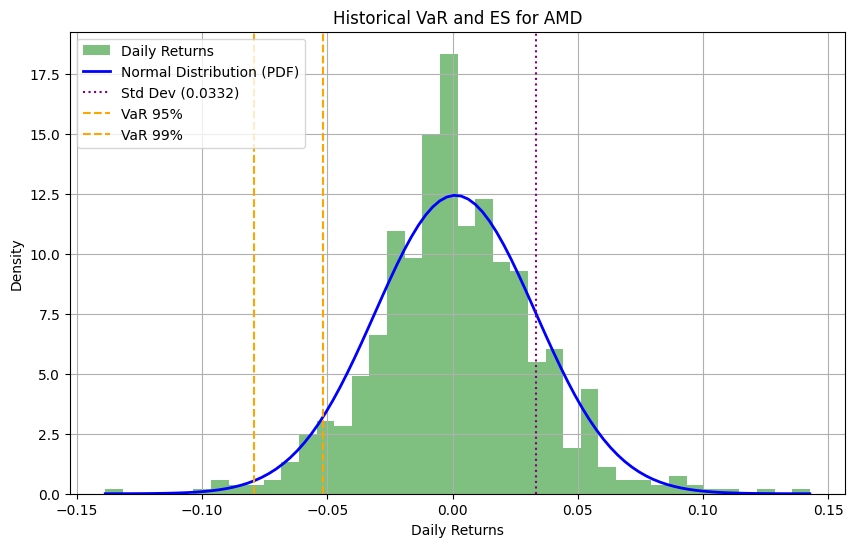


Historical Portfolio VaR and ES
Historical Portfolio VaR and ES at 95% confidence level: VaR=-0.0381, ES=-0.0512, Extreme Loss=5.00%
Historical Portfolio VaR and ES at 99% confidence level: VaR=-0.0582, ES=-0.0688, Extreme Loss=1.00%


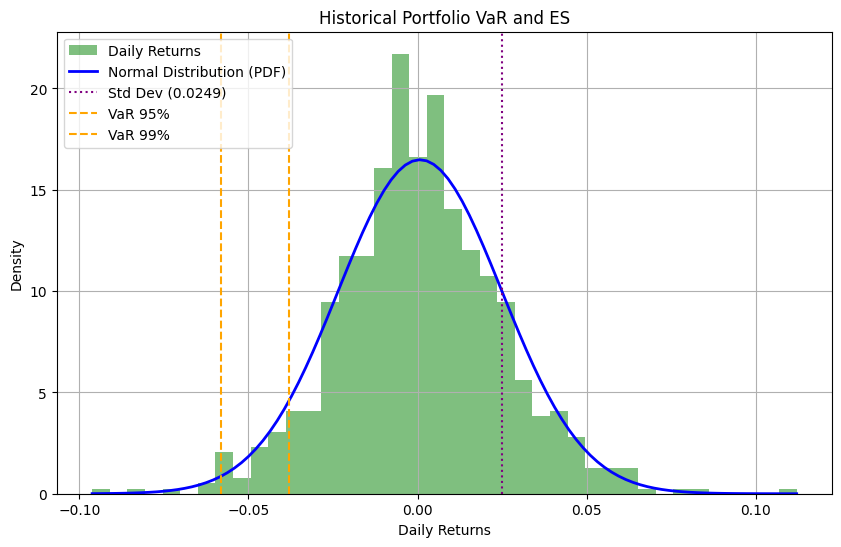

In [ ]:
#Inspriation for code taken from the following link https://blog.quantinsti.com/calculating-value-at-risk-in-excel-python/

# Importing necessary libraries
# numpy: a powerful numerical library, especially useful for handling arrays and matrix calculations.
# pandas: useful for data manipulation, particularly for organising data in DataFrames (tables).
# yfinance: a library to fetch historical stock data directly from Yahoo Finance.
# scipy.stats.norm: provides statistical functions, specifically for calculating z-scores and probability distributions.
# matplotlib.pyplot: used for visualising data, specifically for plotting histograms and curves.
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Setting the date range for our analysis and defining which stocks (tickers) we’re interested in.
# start_date and end_date define the timeframe of historical data we want.
# tickers is a list containing stock symbols (in this case, Intel and AMD) that we’ll be analysing for risk measures.
start_date, end_date = "2021-01-01", "2023-12-31"
tickers = ["INTC", "AMD"]

# Downloading historical daily closing prices for each stock in the tickers list.
# price_data is a dictionary where each key is a stock ticker symbol, and the corresponding value is a DataFrame of closing prices.
# We then calculate daily returns for each stock by finding the percentage change in these closing prices, stored in the DataFrame daily_returns.
price_data = {ticker: yf.download(ticker, start=start_date, end=end_date)[['Close']] for ticker in tickers}
daily_returns = pd.DataFrame({ticker: data['Close'].pct_change().squeeze() for ticker, data in price_data.items()})

# Defining confidence levels for our Value at Risk (VaR) calculations.
# confidence_percentages contains the confidence levels we’re interested in for assessing risk (95% and 99% in this case).
# confidence_levels converts these percentages to decimal form (0.95 and 0.99).
# tail_probabilities is calculated as (1 - confidence level), representing the likelihood of extreme losses.
confidence_percentages = [95, 99]
confidence_levels = [p / 100 for p in confidence_percentages]
tail_probabilities = [1 - level for level in confidence_levels]

# Function to calculate Value at Risk (VaR) and Expected Shortfall (ES).
# This function takes the average return, standard deviation, and the confidence levels to compute VaR and ES.
# avg_return: the average daily return of the stock or portfolio.
# std_dev: the standard deviation of daily returns, which represents volatility.
# confidence_levels: the levels of confidence for the VaR calculation (e.g., 95%, 99%).
# tail_probs: the probabilities for extreme losses beyond each confidence level.
# The function returns a dictionary with the VaR and ES for each confidence level.
def calculate_var_es(avg_return, std_dev, confidence_levels, tail_probs):
    var_es = {}
    for cl, tail_prob in zip(confidence_levels, tail_probs):
        # Calculate the z-score for each confidence level, which tells us how many standard deviations we move from the mean.
        z_score = norm.ppf(1 - cl)

        # Calculate VaR as the mean return plus the z-score scaled by standard deviation.
        var = avg_return + z_score * std_dev

        # Calculate ES as the expected loss beyond the VaR threshold.
        es = avg_return - (std_dev * norm.pdf(z_score) / tail_prob)

        # Store the calculated VaR, ES, and tail probability in the dictionary for this confidence level.
        var_es[cl] = (var, es, tail_prob)
    return var_es

# Function to display and plot VaR/ES values with a histogram of daily returns.
# data: the daily returns for an individual stock or a portfolio.
# var_es: a dictionary containing the VaR and ES values for the specified confidence levels.
# title: the title of the plot, indicating the stock or portfolio being analysed.
def print_and_plot_var_es(data, var_es, title):
    # Print the VaR, ES, and the probability of extreme loss (tail probability) for each confidence level.
    print(f"\n{title}")
    for cl, (var, es, tail_prob), conf_percent in zip(var_es.keys(), var_es.values(), confidence_percentages):
        print(f"{title} at {conf_percent}% confidence level: VaR={var:.4f}, ES={es:.4f}, Extreme Loss={tail_prob*100:.2f}%")

    # Plot a histogram of daily returns with green bars to visualise the distribution of returns.
    plt.figure(figsize=(10, 6))
    data.hist(bins=40, density=True, histtype='stepfilled', alpha=0.5, color='green', label="Daily Returns")

    # Overlay a normal distribution curve (Probability Density Function) based on the mean and standard deviation of returns.
    # This curve helps visualise the theoretical distribution of possible returns.
    x = np.linspace(data.min(), data.max(), 100)
    pdf = norm.pdf(x, data.mean(), data.std())
    plt.plot(x, pdf, color='blue', linewidth=2, label="Normal Distribution (PDF)")

    # Plot a single vertical line indicating the exact standard deviation value from the mean.
    std_dev_value = data.mean() + data.std()
    plt.axvline(std_dev_value, color='purple', linestyle=':', linewidth=1.5, label=f"Std Dev ({std_dev_value:.4f})")

    # Plot vertical lines for the VaR thresholds for each confidence level.
    for cl, conf_percent in zip(var_es.keys(), confidence_percentages):
        plt.axvline(x=var_es[cl][0], color='orange', linestyle='--', label=f"VaR {conf_percent}%")

    # Set the plot title and axis labels.
    plt.title(title)
    plt.xlabel("Daily Returns")
    plt.ylabel("Density")

    # Display a legend in the upper left corner showing the daily returns, the PDF curve, and the VaR lines.
    plt.legend(loc="upper left")
    plt.show()

# Output 1 and 2: Statistical Approach - Calculate and plot VaR and ES for each stock.
# For each stock ticker, we calculate the average and standard deviation of daily returns.
# Then, we calculate and plot VaR and ES using the statistical (variance-covariance) approach, assuming returns are normally distributed.
for ticker in tickers:
    avg, std = daily_returns[ticker].mean(), daily_returns[ticker].std()
    var_es = calculate_var_es(avg, std, confidence_levels, tail_probabilities)
    print_and_plot_var_es(daily_returns[ticker], var_es, f"Statistical VaR and ES for {ticker}")

# Output 3: Statistical Approach - Calculate and plot VaR and ES for a portfolio.
# Here, we define equal weights (50% each) for Intel and AMD in the portfolio.
# We then calculate the portfolio’s mean return and standard deviation by combining the returns of both stocks.
# Finally, we calculate and plot VaR and ES for the portfolio using the variance-covariance approach.
portfolio_weights = np.array([0.5, 0.5])
portfolio_avg = np.dot(portfolio_weights, daily_returns.mean())
portfolio_std = np.sqrt(np.dot(portfolio_weights.T, np.dot(daily_returns.cov(), portfolio_weights)))
portfolio_var_es = calculate_var_es(portfolio_avg, portfolio_std, confidence_levels, tail_probabilities)
print_and_plot_var_es(daily_returns.dot(portfolio_weights), portfolio_var_es, "Statistical Portfolio VaR and ES")

# Output 4 and 5: Historical Simulation Approach - Calculate and plot VaR and ES for each stock.
# In this approach, VaR and ES are based on actual historical data without assuming a normal distribution of returns.
# For each confidence level, VaR is calculated as the quantile of returns, and ES is the average of returns that exceed the VaR threshold.
for ticker in tickers:
    historical_var_es = {cl: (daily_returns[ticker].quantile(1 - cl),
                              daily_returns[ticker][daily_returns[ticker] <= daily_returns[ticker].quantile(1 - cl)].mean(),
                              1 - cl) for cl in confidence_levels}
    print_and_plot_var_es(daily_returns[ticker], historical_var_es, f"Historical VaR and ES for {ticker}")

# Output 6: Historical Simulation Approach - Calculate and plot VaR and ES for the portfolio.
# Similar to individual stocks, we calculate VaR and ES for the portfolio based on historical returns.
# VaR is the quantile of portfolio returns, and ES is the mean of returns that are below the VaR threshold.
portfolio_returns = daily_returns.dot(portfolio_weights)
historical_portfolio_var_es = {cl: (portfolio_returns.quantile(1 - cl),
                                    portfolio_returns[portfolio_returns <= portfolio_returns.quantile(1 - cl)].mean(),
                                    1 - cl) for cl in confidence_levels}
print_and_plot_var_es(portfolio_returns, historical_portfolio_var_es, "Historical Portfolio VaR and ES")

